<a href="https://colab.research.google.com/github/deepthivj-aiml/Anomaly-Detection/blob/main/Anomaly_Detection_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded. Shape: (50000, 31)
Heuristic anomalies flagged: 6896
Training Autoencoder...
Epoch 10, Loss: 0.7675
Epoch 20, Loss: 0.4465
Epoch 30, Loss: 0.3110
Epoch 40, Loss: 0.2265
Epoch 50, Loss: 0.1855
Training XGBoost Judge...

--- Model Performance Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8605
           1       0.99      0.99      0.99      1395

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



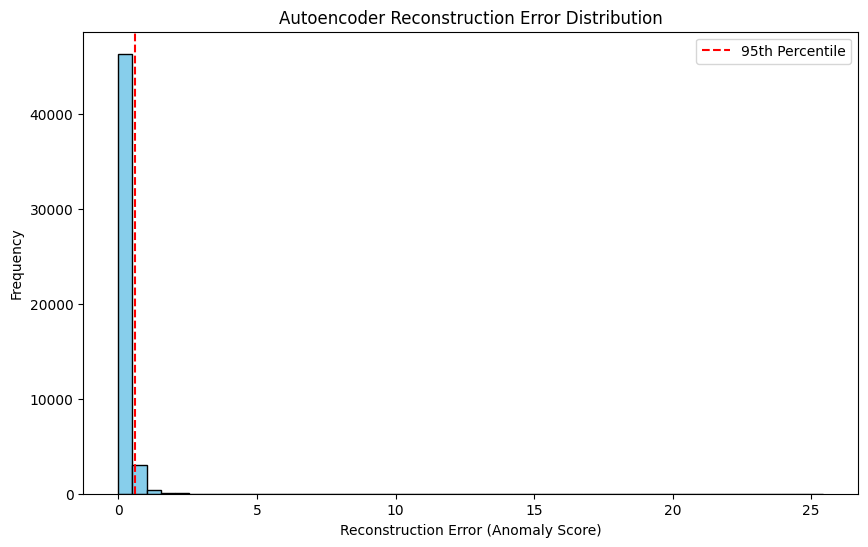

In [7]:
# Single-Cell Colab: Hybrid Anomaly Detection
!pip install --quiet scikit-learn xgboost pandas numpy matplotlib seaborn torch

import pandas as pd
import numpy as np
import os
import urllib.request
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# -----------------------------
# Step 0: Download Public Dataset (Stable Mirror)
# -----------------------------
# Using a reliable raw link for the Credit Card Fraud dataset
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
file_path = "creditcard.csv"

if not os.path.exists(file_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, file_path)

# Load and sample for speed
df = pd.read_csv(file_path).sample(50000, random_state=42)
print(f"Dataset loaded. Shape: {df.shape}")

# -----------------------------
# Step 1: Heuristic Pseudo-Labels
# -----------------------------
# Bootstrap labels based on expert rules (High Amount or V1 Outlier)
df['heuristic_label'] = ((df['Amount'] > 200) | (df['V1'] < -3)).astype(int)
print(f"Heuristic anomalies flagged: {df['heuristic_label'].sum()}")

# -----------------------------
# Step 2: Feature Engineering
# -----------------------------
features = ['Amount','V1','V2','V3','V4','V5','V6']
df_feat = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat)

# -----------------------------
# Step 3: Autoencoder (The Neural Intuition)
# -----------------------------
class AE(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_features, 16), nn.ReLU(), nn.Linear(16, 8))
        self.decoder = nn.Sequential(nn.Linear(8, 16), nn.ReLU(), nn.Linear(16, n_features))
    def forward(self, x):
        return self.decoder(self.encoder(x))

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
ae = AE(X_scaled.shape[1])
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()

print("Training Autoencoder...")
for epoch in range(50): # Increased epochs for better convergence
    optimizer.zero_grad()
    loss = criterion(ae(X_tensor), X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Compute Reconstruction Error (Anomaly Score)
with torch.no_grad():
    recon = ae(X_tensor)
    errors = torch.mean((recon - X_tensor)**2, dim=1).numpy()

# -----------------------------
# Step 4: Hybrid Fusion (XGBoost)
# -----------------------------
df['ae_score'] = errors
df['ae_score_scaled'] = StandardScaler().fit_transform(df[['ae_score']])

# Fuse raw features with AE score
X_final = np.hstack([X_scaled, df['ae_score_scaled'].values.reshape(-1, 1)])
y = df['heuristic_label'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print("Training XGBoost Judge...")
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------------
# Step 5: Final Evaluation
# -----------------------------
print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred))

# Visualize the Anomaly Distribution
plt.figure(figsize=(10,6))
plt.hist(df['ae_score'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(df['ae_score'], 95), color='red', linestyle='--', label='95th Percentile')
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

NameError: name 'model' is not defined